In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [12]:
import torchvision
from torchvision import datasets, models, transforms

In [13]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
import json
import cv2
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict

In [14]:
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
torch.cuda.is_available(), torch.cuda.get_device_name(0), torch.backends.cudnn.enabled

(True, 'GeForce GTX 960M', True)

In [17]:
DATA_PATH = Path('C:/fastai/courses/dl2/data/road_damage_dataset')

In [18]:
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'

In [19]:
im_size = 224

In [22]:
train_tfms = TransformList([
        RandomScale(im_size, 1.2),
        RandomCrop(im_size),
        RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = TransformList([
        Scale(im_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [23]:
batch_size = 4
data = ImageData.from_csv(DATA_PATH, MULTICLASS_CSV_PATH, batch_size, train_tfms, val_tfms)
num_classes = 8

In [24]:
model_ft = models.resnet18(pretrained=True)
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Dropout(p=.5),
    nn.Linear(num_ftrs, num_classes),
    nn.Sigmoid()
)

In [25]:
criterion = nn.BCELoss()
optim_fn = optim.Adam

In [26]:
sess = Session(model_ft, criterion, optim_fn, [*[1e-3] * 9, 1e-2])

In [27]:
sess.freeze() 

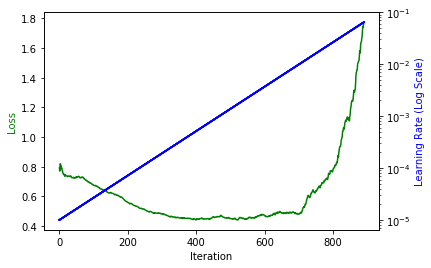

In [28]:
lr_find(sess, data['train'], start_lr=1e-5)

In [29]:
sess.set_lr(1e-3)

In [30]:
accuracy = NHotAccuracy(num_classes)
validator = Validator(data['valid'], accuracy)
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
schedule = TrainingSchedule(data['train'], [validator, lr_scheduler])

sess.train(schedule, 3)

Training Loss: 0.422224  Validaton Loss: 0.382788 Validation Accuracy: 0.829797


Training Loss: 0.410648  Validaton Loss: 0.398360 Validation Accuracy: 0.829351


Training Loss: 0.401048  Validaton Loss: 0.369944 Validation Accuracy: 0.835770


In [31]:
for detail in accuracy.details:
    print(detail)

{'correct_pos': 9, 'correct_neg': 1061, 'false_pos': 6, 'false_neg': 326}
{'correct_pos': 150, 'correct_neg': 789, 'false_pos': 60, 'false_neg': 403}
{'correct_pos': 0, 'correct_neg': 1318, 'false_pos': 0, 'false_neg': 84}
{'correct_pos': 0, 'correct_neg': 1290, 'false_pos': 0, 'false_neg': 112}
{'correct_pos': 135, 'correct_neg': 948, 'false_pos': 75, 'false_neg': 244}
{'correct_pos': 0, 'correct_neg': 1353, 'false_pos': 0, 'false_neg': 49}
{'correct_pos': 19, 'correct_neg': 1280, 'false_pos': 6, 'false_neg': 97}
{'correct_pos': 183, 'correct_neg': 839, 'false_pos': 118, 'false_neg': 262}


In [32]:
sess.save('TrainLayer1')

In [33]:
sess.load('TrainLayer1')

In [34]:
sess.unfreeze()

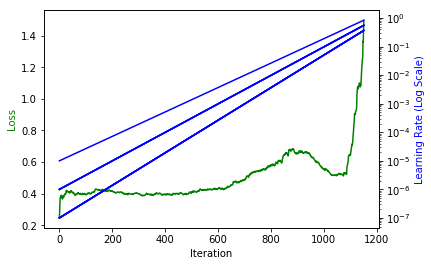

In [35]:
lr_find(sess, data['train'], start_lr=[*[1e-5 / 100] * 5, *[1e-5 / 10] * 4, 1e-5])

In [ ]:
sess.set_lr([*[1e-4 / 100] * 5, *[1e-4 / 10] * 4, 1e-4])

In [ ]:
accuracy = NHotAccuracy(num_classes)
validator = Validator(data['valid'], accuracy)
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
schedule = TrainingSchedule(data['train'], [validator, lr_scheduler])

sess.train(schedule, 7)

In [ ]:
for detail in accuracy.details:
    print(detail)

In [ ]:
lr_scheduler.plot()

In [ ]:
sess.save('FullTrain')

In [ ]:
sess.load('FullTrain')

In [ ]:
sess.train(schedule, 8)

In [ ]:
sess.save('FullTrain2')

In [ ]:
sess.load('FullTrain2')